In [98]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random

In [106]:
def get_data():
    p = 0.01  
    names = [i for i in range(785)]
    dataset = pd.read_csv('A_Z Handwritten Data.csv', names=names,skiprows=lambda i: i>0 and random.random() > p)
    X = dataset.loc[:,1:]
    X = X/255
    Y = dataset.loc[:,0]
    enc = OneHotEncoder()
    Y = enc.fit_transform(np.array(Y).reshape(-1,1))
    #print(Y.toarray().shape)
    #print(type(Y.toarray()))
    #images = np.multiply(images, 1.0 / 255.0)
    # split the data into training (80%) and testing (20%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.20)
    return X_train.values, X_test.values, Y_train.toarray(), Y_test.toarray()

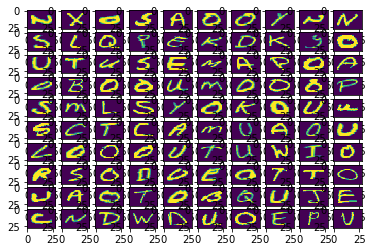

In [108]:
def visualize_data():
    X_train, X_test ,Y_train, Y_test  = get_data()
    # visualize data by plotting images 
    fig,ax = plt.subplots(10,10) 
    k = 0
    for i in range(10): 
        for j in range(10): 
            ax[i][j].imshow(X_train[k].reshape(28,28), aspect='auto') 
            k += 1
    plt.show() 

visualize_data()

In [100]:
def predictor():
    X_train, X_test ,Y_train, Y_test  = get_data()
    N = X_train.shape[1]
    #Defining number of neuron units in each layer
    neurons1 = 512
    neurons2 = 256
    neurons3 = 128
    outputl = 26

    #Session creation
    session = tf.InteractiveSession()

    #Placeholders for inputs
    X = tf.placeholder(dtype = tf.float32, shape =[None,N])
    Y = tf.placeholder(dtype = tf.float32, shape = [None,26])

    #Initialisers for weights and biases
    sigma = 1
    weights_in_1 = tf.random_normal_initializer(stddev=(2.0/N)**0.5)
    weights_in_2 = tf.random_normal_initializer(stddev=(2.0/neurons1)**0.5)
    weights_in_3 = tf.random_normal_initializer(stddev=(2.0/neurons2)**0.5)
    weights_in_4 = tf.random_normal_initializer(stddev=(2.0/neurons3)**0.5)
    biases_in = tf.zeros_initializer()

    #hidden weights
    w_1 = tf.Variable(weights_in_1([N,neurons1]))
    b_1 = tf.Variable(biases_in([neurons1]))
    w_2 = tf.Variable(weights_in_2([neurons1,neurons2]))
    b_2 = tf.Variable(biases_in([neurons2]))
    w_3 = tf.Variable(weights_in_3([neurons2,neurons3]))
    b_3 = tf.Variable(biases_in([neurons3]))

    #Output weights
    out_w = tf.Variable(weights_in_4([neurons3,outputl]))
    out_b = tf.Variable(biases_in(outputl))


    #Saver to save weights
    saver = tf.train.Saver()


        #256*784  784*512  = 256*512
        #256*512  512*256  = 256*256
        #256*256  256*128  = 256*128
        #256*128  128*26 = 256*26

    #Defining hidden layers
    hidden_1 = tf.nn.relu(tf.add(tf.matmul(X,w_1),b_1))
    hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1,w_2),b_2))
    hidden_3 = tf.add(tf.matmul(hidden_2,w_3),b_3)

    #Output layer
    output = tf.nn.relu(tf.add(tf.matmul(hidden_3,out_w),out_b))

    #Cost function
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = Y))
    #Optimizer(Stochastic gradient extension)

    optimizer = tf.train.AdamOptimizer().minimize(cost)

    #Calling Initialisers
    session.run(tf.global_variables_initializer())
    #new_saver = tf.train.import_meta_graph('my_test_model-1000.meta')
    #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    
    #Plotting
    plt.ion()
    fig = plt.figure(figsize = (10,12))

    #fit neural sessionwork
    batch_size = 262
    mse_train = []
    mse_test = []

    epoches = 15
    for e in range(0,epoches):

        #shuffle training data
        shuffle_indices = np.random.permutation(np.arange(len(Y_train)))
        X_train = X_train[shuffle_indices]
        Y_train = Y_train[shuffle_indices]

        #minibatch training
        for i in range(0,len(Y_train)//batch_size):
            start = i*batch_size
            batch_x = X_train[start:start+batch_size]
            batch_y = Y_train[start:start+batch_size]
            
            #run optimizer
            session.run(optimizer,feed_dict={X:batch_x,Y:batch_y})            
            #show progress
            if np.mod(i,50) == 0:
                #MSE train and test
                mse_train.append(session.run(cost,feed_dict={X:X_train,Y:Y_train}))
                mse_test.append(session.run(cost,feed_dict={X:X_test,Y:Y_test}))
                print('MSE Train: ', mse_train[-1])
                print('MSE Test: ', mse_test[-1])
        
        saver.save(session,'model_data/',global_step =0)


# Define the loss function
#print(loss.eval())
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output), 1), tf.argmax(Y,1))
# Operation calculating the accuracy of our predictions
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(session.run(accuracy,feed_dict={X:X_test,Y:Y_test}))
    p = tf.argmax(tf.nn.softmax(output),1)
    print(session.run(p,feed_dict={X:X_test[0].reshape(1,-1)}))
    print(Y_test[0])
    session.close()
# Operation comparing prediction with true label


In [101]:
predictor()

/home/shivam/gitRepos/neuralNetworks/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


MSE Train:  3.00391
MSE Test:  2.9809742
MSE Train:  1.7671416
MSE Test:  1.8177596
MSE Train:  1.1514518
MSE Test:  1.2319064
MSE Train:  0.8926853
MSE Test:  1.0236515
MSE Train:  0.7062633
MSE Test:  0.88062215
MSE Train:  0.59479386
MSE Test:  0.8116394
MSE Train:  0.49417016
MSE Test:  0.75944597
MSE Train:  0.41548914
MSE Test:  0.7011648
MSE Train:  0.36691612
MSE Test:  0.6865935
MSE Train:  0.33529136
MSE Test:  0.67685956
MSE Train:  0.30115107
MSE Test:  0.659449
MSE Train:  0.28519607
MSE Test:  0.679567
MSE Train:  0.26492965
MSE Test:  0.6557369
MSE Train:  0.24442111
MSE Test:  0.6559898
MSE Train:  0.23311713
MSE Test:  0.64896953
0.8442077
[15]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


<Figure size 720x864 with 0 Axes>